# William Harris
## Exam 3 - Choice B

While trees  suffer from high dimensionality too, it is possible to work with more than a few features per
model. Produce two models: (1) initial mapping model with many features, and (2) reduced in features
model that aims to improve prediction of negative moves as well as (3) study design for a boosted model.

In [1]:
from collections import Counter
from dataclasses import dataclass
from datetime import datetime
from itertools import product

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from bfxapi import Client
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.feature_selection import RFE, VarianceThreshold, mutual_info_classif
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, log_loss
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from xgboost import XGBClassifier, XGBRegressor
import graphviz
from IPython.display import Image
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.base import is_regressor
import quantstats as qs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

c:\Users\William.Harris\.conda\envs\exam3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Question 2. Implementation tasks for models type (1), (2) as appropriate.
- Vary hyperparameters (min number to split, minimum number in leaf, and maximum depth) –
can use ready search RandomizedSearchCV, GridSearchCV. While you are not required to generate
surfaces, please.
- Formulate up to four principles/purposes of trees pruning. Illustrate with model type (2) vs (1) as
appropriate.
- Provide attribution to splits (discuss if they are sensible), particularly for the model type (2) better
negative moves classification.
- Provide plots for decision boundaries (surfaces), and name two specific issues for prediction quality
of tree models. Investigate the prediction quality using area under ROC curve (each class) and
confusion matrix. Do report on results for train/test split (typically, 50%/50% of observations).

##### 1. Data Collection

In [2]:
async def save_data():
    BfxRest = Client()
    end = datetime(2022, 5, 28).timestamp() * 1000.0
    data = await BfxRest.rest.get_public_candles("tBTCUSD", 0, end, section='hist', tf='1D', limit='10000', sort=-1)

    df= pd.DataFrame(data, columns=['DATE', 'OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME'])
    df['DATE'] = pd.to_datetime(df['DATE'],unit='ms')
    df.sort_index(ascending=False, inplace=True)
    df.to_csv('Bitcoin_OHLC.csv', index=False)

#await save_data()

##### 2. Prepare data

(Timestamp('2013-03-31 00:00:00', freq='D'),
 Timestamp('2022-05-27 00:00:00', freq='D'))

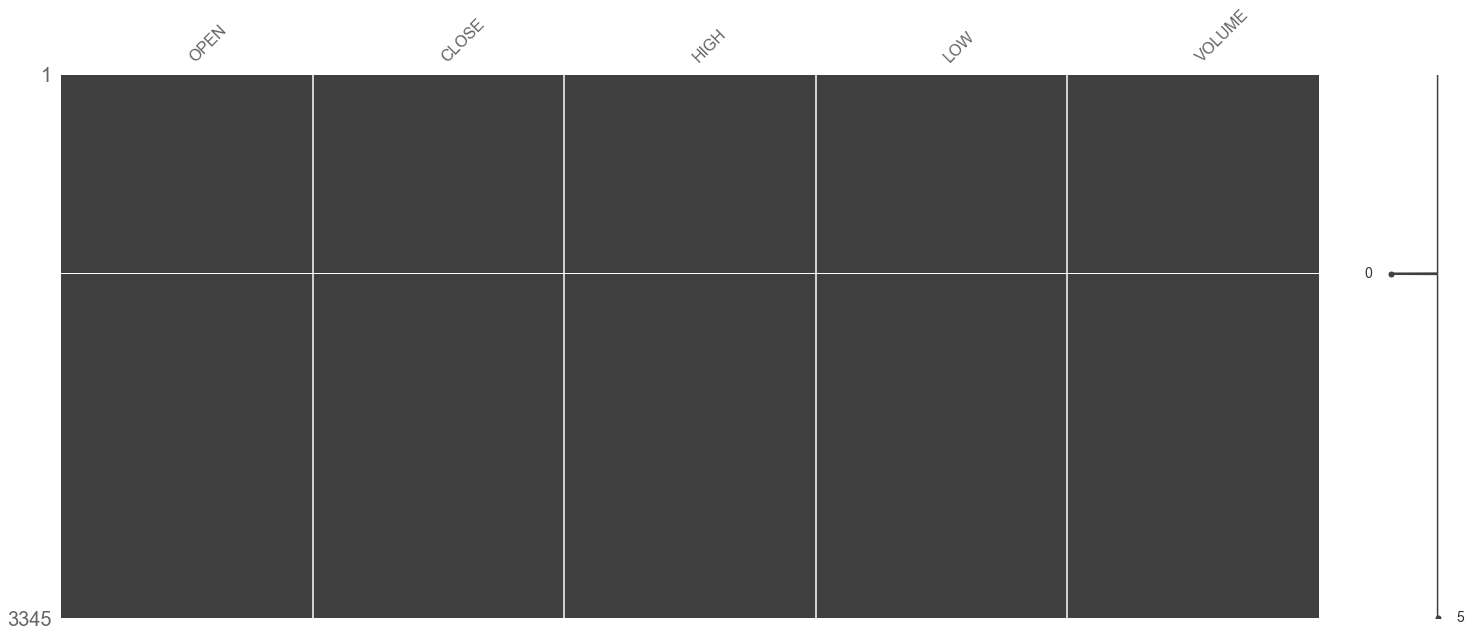

In [3]:
def load_data():
    df = pd.read_csv('Bitcoin_OHLC.csv')
    df['DATE'] = pd.to_datetime(df.DATE)
    d_range = pd.date_range(df.DATE.min(), df.DATE.max())
    return pd.DataFrame(index=d_range).join(df.set_index('DATE'))

%matplotlib inline
df = load_data()
msno.matrix(df)
df[df.isna().any(axis=1)]
df.index.min(), df.index.max()

In [4]:
@dataclass
class Data:
    cols: list = None
    non_features: list =  ('TARGET', 'DATE', 'CLOSE', 'HIGH', 'LOW', 'OPEN', 'VOLUME', 'RETURN')

    def __post_init__(self):
        self.__df = self.preprocess_data()
        self.__df = self.add_all_features(self.__df)
        self.__df = self.add_target(self.__df)
        self.__df.dropna(inplace=True)
        if self.cols is not None:
            self.__df = self.__df[self.cols + list(self.non_features)]
        self.stage_data()
        print(f'Number of data points per label: Train->{Counter(self.y_train)}, Test->{Counter(self.y_test)}')

    @property
    def df_features(self):
        return self.__df.drop(list(self.non_features), axis=1)
    
    @property
    def df(self):
        return self.__df

    @staticmethod
    def add_target(df):
        df['TARGET'] = df.CLOSE.pct_change().shift(-1).apply(lambda x: 1 if x > 0 else 0)
        return df

    @staticmethod
    def add_all_features(df):
        df['RETURN'] = np.log(df.CLOSE).diff()
        df['O_C'] = df.OPEN - df.CLOSE
        df['H_L'] = df.HIGH - df.LOW
        
        for r in list(range(1,6)) + list(range(10, 60, 5)):
            df[f'MOMENTUM_{r}D'] = df['CLOSE']-df['CLOSE'].shift(periods=r)
            if r > 4:
                df[f'MA_{r}D'] = df['CLOSE'].rolling(r).mean()
                df[f'EMA_{r}D'] = df['CLOSE'].ewm(r, adjust=False).mean()

        return df

    @staticmethod
    def downsample(df):
        dfs = []
        minimum = df.TARGET.value_counts().min()
        for target in df.TARGET.unique():
            dfs.append(df[df.TARGET == target].sample(n=minimum, random_state=1))
        return pd.concat(dfs)

    def stage_data(self):
        split_at = round(len(self.__df) * 0.8)
        df1 = self.__df.iloc[:split_at].copy()
        df2 = self.__df.iloc[split_at:].copy()
        #df1 = self.downsample(df1).sort_values('DATE')
        self.y_train = df1.TARGET.values
        self.y_test = df2.TARGET.values

        for col in self.non_features:
            if col in df1.columns:
                df1.drop(col, axis=1, inplace=True)
            if col in df2.columns:
                df2.drop(col, axis=1, inplace=True)

        self.X_train = df1.values
        self.X_test = df2.values
        self.features = list(df2.columns)
    
    @staticmethod
    def preprocess_data():
        df = load_data()
        df.fillna(method="ffill", inplace=True)
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'DATE'}, inplace=True)
        return df

In [5]:
class Model:
    def __init__(self, model_obj: object, staged_data: Data, **kwargs):
        self.model_obj = model_obj
        self.staged_data = staged_data
        self.__ml_kwargs = kwargs
        self.model = None
        self.is_regressor = is_regressor(model_obj())
    
    def predict(self, X):
        prediction = self.model.predict(X)
        if self.is_regressor:
            prediction = np.where(prediction > 0.5, 1, 0)
        return prediction

    def fit(self, fit_params={}, other_ml_kwargs={}):
        self.model = self.model_obj(**self.__ml_kwargs, **other_ml_kwargs)
        self.model.fit(self.staged_data.X_train, self.staged_data.y_train, **fit_params)
                
        if self.is_regressor:
            pred_train_probs = self.model.predict(self.staged_data.X_train)
            pred_test_probs = self.model.predict(self.staged_data.X_test)
        else:
            pred_train_probs = self.model.predict_proba(self.staged_data.X_train)[:,1]
            pred_test_probs = self.model.predict_proba(self.staged_data.X_test)[:,1]

        acc_train = accuracy_score(self.staged_data.y_train, self.predict(self.staged_data.X_train))
        acc_test = accuracy_score(self.staged_data.y_test, self.predict(self.staged_data.X_test))
        loss_train = log_loss(self.staged_data.y_train, pred_train_probs)
        loss_test = log_loss(self.staged_data.y_test, pred_test_probs)

        print(f'Train Accuracy: {acc_train:.4f} Train Loss: {loss_train:.4f}')
        print(f'Test Accuracy: {acc_test:.4f} Test Loss: {loss_test:.4f}')
        return self.model

    def cross_validation_train(self, cv_params, fit_params={}, cv_obj=GridSearchCV):

        cv = cv_obj(self.model_obj(**self.__ml_kwargs), **cv_params, error_score="raise")
        cv.fit(self.staged_data.X_train, self.staged_data.y_train, **fit_params)

        print(cv.set_params())
        print("Tuned Decision Tree Parameters with GridSearchCV: {}".format(cv.best_params_))
        print("Best score is {}".format(cv.best_score_))
        self.fit(fit_params=fit_params, other_ml_kwargs=cv.best_params_)
        return cv
    
    def confusion_matrix(self):
        ConfusionMatrixDisplay.from_predictions(self.staged_data.y_test, self.predict(self.staged_data.X_test))
        plt.show()

    def feature_importance(self):
        feature_imp = pd.DataFrame({'Importance Score': self.model.feature_importances_,'Features': self.staged_data.features}).sort_values(by='Importance Score', ascending=False)
        feature_imp = feature_imp[feature_imp['Importance Score'] > 0].head(10)
        sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
        plt.show()
    
    def roc_curve(self):
        _, ax = plt.subplots()
        RocCurveDisplay.from_predictions(self.staged_data.y_test, self.predict(self.staged_data.X_test), ax=ax)
        ax.plot([0,1], [0,1], linestyle='--')
        plt.show()
    
    def classification_report(self):
        print(classification_report(self.staged_data.y_test, self.predict(self.staged_data.X_test)))
    
    def plot_tree(self, name, max_depth=None):
        dot_data = export_graphviz(self.model, feature_names=self.staged_data.features, class_names=['Down Trend', 'Up Trend'], rounded=True, filled=True, proportion=True, max_depth=max_depth)
        graph = graphviz.Source(dot_data, filename=name, format='png')
        graph.render()
    
    def decision_boundaries(self, index):
        fig, ax = plt.subplots()
        x = self.staged_data.df_features.describe().loc['mean'].to_dict()
        plot_decision_regions(self.staged_data.X_train, self.staged_data.y_train, clf=self.model,
                            feature_index=index,
                            filler_feature_values={i: value for i, value in enumerate(x.values()) if i not in index},
                            filler_feature_ranges={i: 10000 for i in range(len(self.staged_data.features)) if i not in index},
                            legend=2, ax=ax)
        ax.set_xlabel(self.staged_data.features[index[0]])
        ax.set_ylabel(self.staged_data.features[index[1]])
        plt.show()


In [6]:
class FeatureSelection:
    @classmethod
    def corr(cls, df):
        corrmat = df.corr()
        _, ax = plt.subplots()
        mask = np.triu(np.ones_like(corrmat, dtype=bool))
        cmap = sns.diverging_palette(250, 15, as_cmap=True)
        sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, 
                        fmt="0.2f", mask=mask, cmap=cmap, vmax=.3, center=0,
                        square=False, linewidths=.5, cbar_kws={"shrink": 1})
        ax.set_title('Feature Correlation', fontsize=14, color='black')
        plt.show()

    @classmethod
    def variance_threshold(cls, df, threshold=0.1) -> pd.Series:
        df = df.drop(['OPEN','CLOSE','HIGH','LOW','VOLUME', 'DATE', 'TARGET', 'RETURN'], axis=1)
        vt = VarianceThreshold(threshold = threshold)
        vt.fit(df)
        return pd.Series(vt.get_feature_names_out(df.columns), name='Variance_Threshold_Ranking').head(10)

    @classmethod
    def mutual_info(cls, data) -> pd.Series:
        mutual_info = mutual_info_classif(data.X_train, data.y_train, random_state=0)
        feature_mutual_info = list(zip(mutual_info, data.features))
        df = pd.DataFrame(feature_mutual_info, columns=['Estimated Mutual Information', 'Mutual_Information_Ranking'])
        return df[df['Estimated Mutual Information'] > 0].sort_values('Estimated Mutual Information', ascending=False).reset_index(drop=True).head(10)['Mutual_Information_Ranking']

    @classmethod
    def rfe(cls, data: Data, model: object, fit_params: dict = {}) -> pd.Series:
        rfe = RFE(model, n_features_to_select=10, step=1)
        rfe.fit(data.X_train,data.y_train, **fit_params)
        return pd.Series(list(feature for feature, support in zip(data.features, rfe.support_) if support), name='RFE_Ranking').head(10)
    
    @classmethod
    def shap_beeswarm(cls, data, model):
        X = data.df.copy()
        non_features = ['TARGET', 'DATE', 'CLOSE', 'HIGH', 'LOW', 'OPEN', 'VOLUME', 'RETURN']
        for col in non_features:
            if col in X.columns:
                X.drop(col, axis=1, inplace=True)
        
        X100 = shap.utils.sample(X, 100, random_state=0)
        model.fit(X, data.df.TARGET)
        explainer = shap.Explainer(model.predict, X100, feature_names=data.features)
        shap_values = explainer(X)
        shap.plots.beeswarm(shap_values, max_display=20)


##### 3.1 Model (1) - Defining Features

##### 3.2 Model (1) - Training

In [7]:
model_1_data = Data()
len(model_1_data.features)

Number of data points per label: Train->Counter({1: 1393, 0: 1239}), Test->Counter({1: 345, 0: 313})


39

Train Accuracy: 1.0000 Train Loss: 0.0000
Test Accuracy: 0.4833 Test Loss: 17.8469


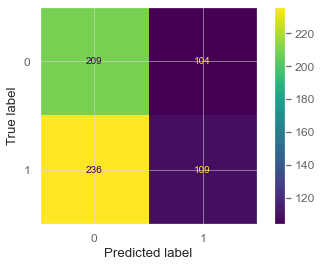

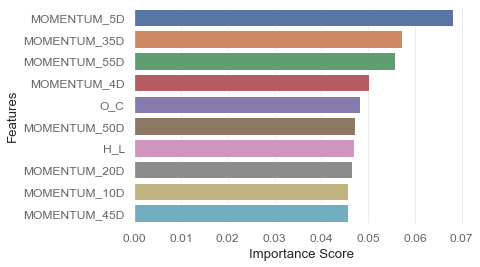

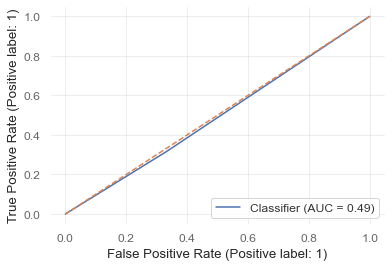

              precision    recall  f1-score   support

           0       0.47      0.67      0.55       313
           1       0.51      0.32      0.39       345

    accuracy                           0.48       658
   macro avg       0.49      0.49      0.47       658
weighted avg       0.49      0.48      0.47       658



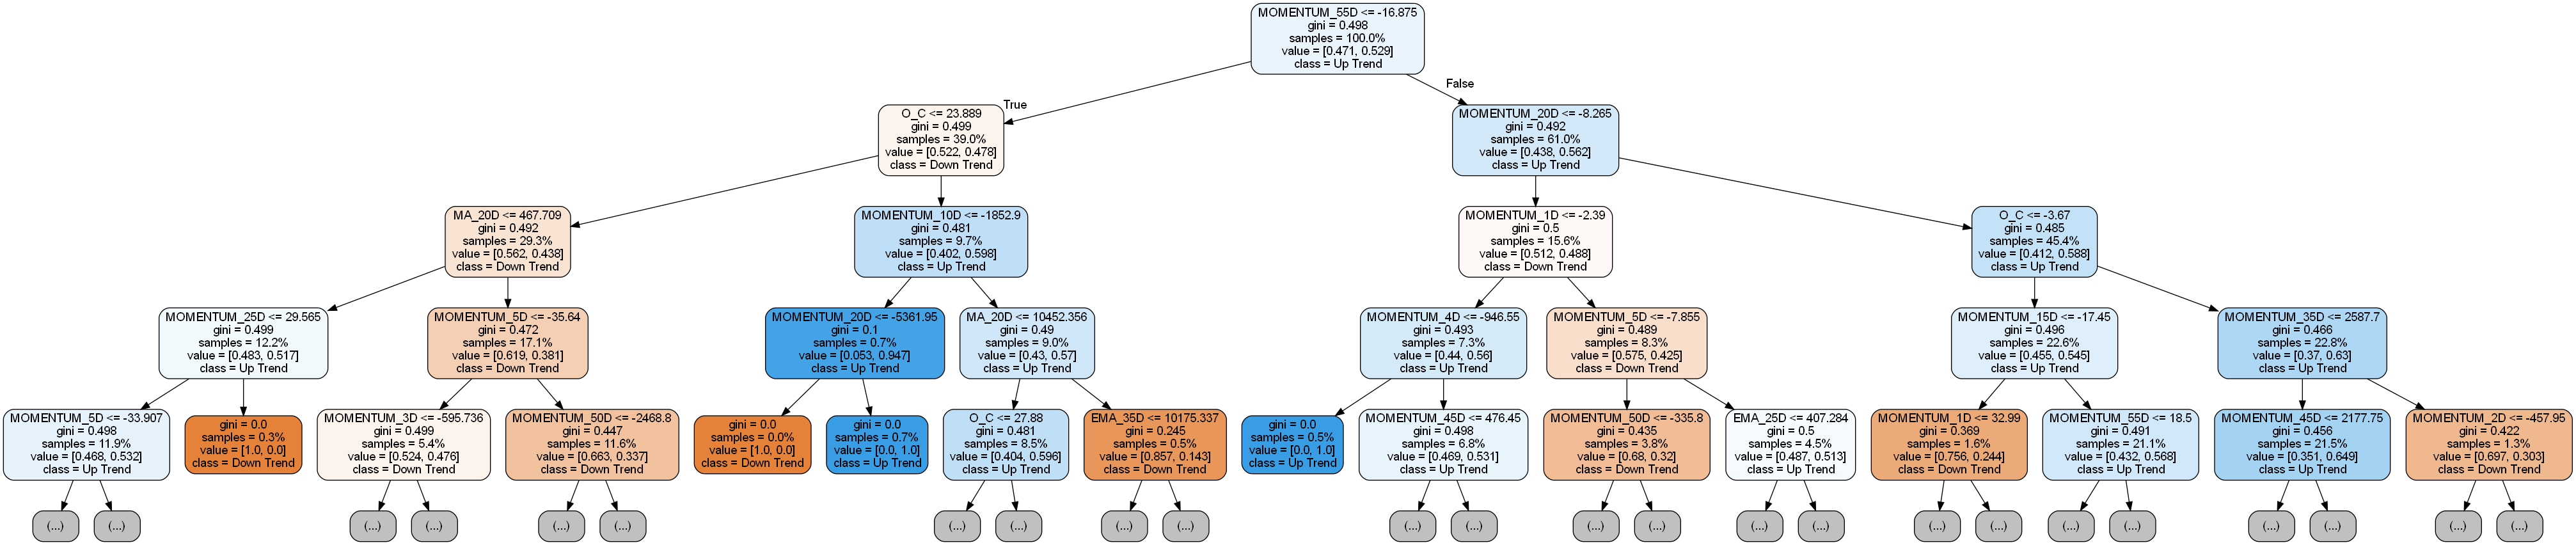

In [8]:
model_1 = Model(DecisionTreeClassifier, model_1_data, random_state=0)
model_1.fit()
model_1.confusion_matrix()
model_1.feature_importance()
model_1.roc_curve()
model_1.classification_report()
model_1.plot_tree('Model_1_tree', 4)
Image('Model_1_tree.png')

##### 4.1 Model (2) - Features Selection

In [9]:
var = FeatureSelection.variance_threshold(model_1_data.df)
mutual_info_series = FeatureSelection.mutual_info(model_1_data)
rfe_series = FeatureSelection.rfe(model_1_data, DecisionTreeClassifier(random_state=0))
pd.concat([var, mutual_info_series, rfe_series], axis=1)

,Variance_Threshold_Ranking,Mutual_Information_Ranking,RFE_Ranking
0,O_C,MOMENTUM_35D,O_C
1,H_L,MOMENTUM_40D,MOMENTUM_2D
2,MOMENTUM_1D,MOMENTUM_25D,MOMENTUM_4D
3,MOMENTUM_2D,MOMENTUM_50D,MOMENTUM_10D
4,MOMENTUM_3D,MOMENTUM_55D,MOMENTUM_15D
5,MOMENTUM_4D,MOMENTUM_1D,MOMENTUM_20D
6,MOMENTUM_5D,MA_15D,MOMENTUM_30D
7,MA_5D,MOMENTUM_45D,MOMENTUM_35D
8,EMA_5D,H_L,MOMENTUM_45D
9,MOMENTUM_10D,MA_55D,EMA_55D


##### 4.1.2 SHAP

Permutation explainer: 3291it [01:34, 31.55it/s]                          


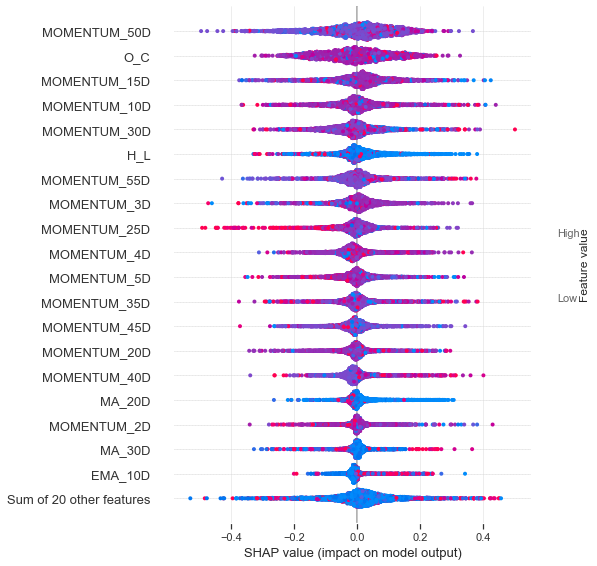

In [10]:
FeatureSelection.shap_beeswarm(model_1_data, DecisionTreeClassifier(random_state=0))

##### 4.3 Model (2) - Feature Selection

In [11]:
data = Data(cols=['O_C', 'MOMENTUM_1D', 'MOMENTUM_2D', 'MOMENTUM_15D', 'MOMENTUM_25D',
                  'MOMENTUM_40D', 'MOMENTUM_45D', 'MOMENTUM_50D', 'MOMENTUM_55D'])

Number of data points per label: Train->Counter({1: 1393, 0: 1239}), Test->Counter({1: 345, 0: 313})


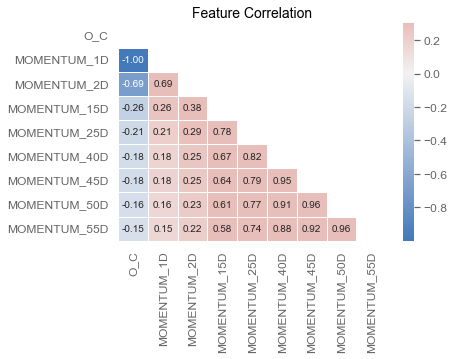

In [12]:
FeatureSelection.corr(data.df_features)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=5,
             param_grid={'max_depth': range(3, 5),
                         'min_samples_leaf': [25, 50, 100],
                         'min_samples_split': [150, 200]},
             return_train_score=True, scoring='balanced_accuracy', verbose=2)
Tuned Decision Tree Parameters with GridSearchCV: {'max_depth': 3, 'min_samples_leaf': 25, 'min_samples_split': 150}
Best score is 0.5375155864659099
Train Accuracy: 0.5866 Train Loss: 0.6737
Test Accuracy: 0.5471 Test Loss: 0.7033


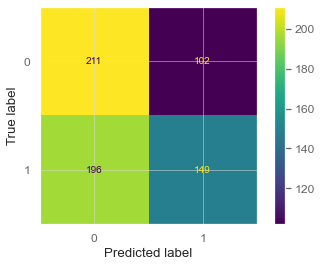

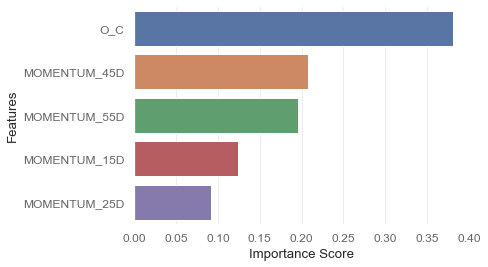

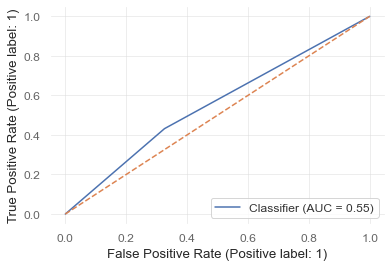

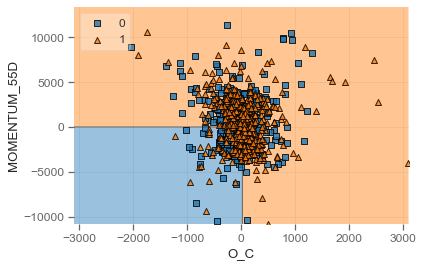

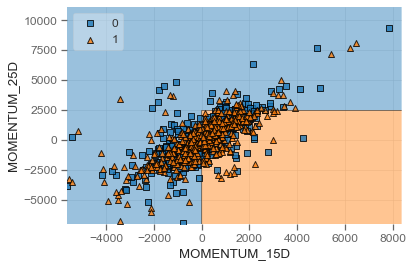

In [13]:
model_2 = Model(DecisionTreeClassifier, data, random_state=0)
param_grid = {"max_depth": range(3, 5),
              "min_samples_leaf": [25, 50, 100],
              "min_samples_split": [150, 200]}
cv_parms={'return_train_score':True, 'verbose':2, 'n_jobs':5, 'param_grid': param_grid, 'cv': TimeSeriesSplit(n_splits=5), 'scoring': 'balanced_accuracy'}
model_2.cross_validation_train(cv_parms)
model_2.confusion_matrix()
model_2.feature_importance()
model_2.roc_curve()
model_2.plot_tree('Model_2_tree')
Image('Model_2_tree.png')
model_2.decision_boundaries((0,8))
model_2.decision_boundaries((3,4))
#for i in range(8):
#    for j in range(8):
#        if j!=i:
#            model_2.decision_boundaries((i,j))


Question 3. Ensemble learning
- Experiment whether to use Adaboost or XGBoost, with which inputs: tree regressor or classifier,
which specific tuned hyperparameters, pruned or non-pruned. Do not present all runs but write
a brief empirical study design for (3) a boosted model of your choice – three paragraphs of text
minimum.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Train Accuracy: 0.9947 Train Loss: 0.2067
Test Accuracy: 0.5182 Test Loss: 0.9204


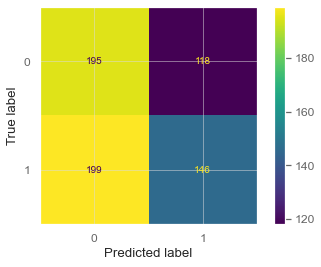

In [14]:
xgboost_model_test = Model(XGBClassifier, data, seed=0)
fit_params={"eval_metric" : "error", "eval_set" : [[data.X_test, data.y_test]], 'verbose': 0}
xgboost_model_test.fit(fit_params)
xgboost_model_test.confusion_matrix()

Number of data points per label: Train->Counter({1: 1393, 0: 1239}), Test->Counter({1: 345, 0: 313})
[19:29:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Permutation explainer: 3291it [03:38, 14.28it/s]                          


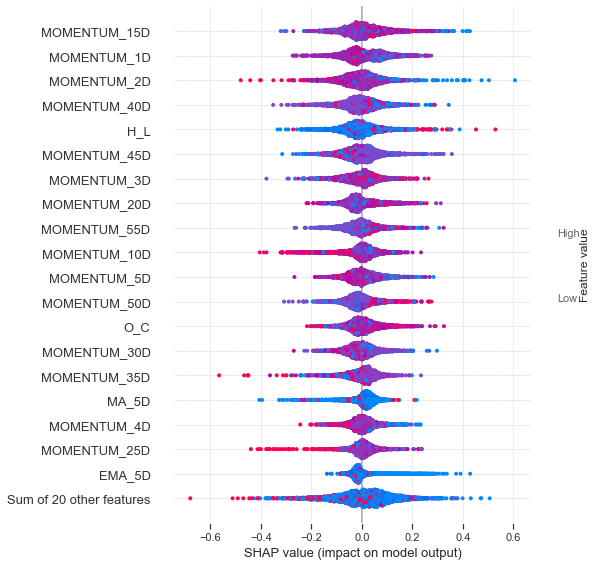

In [15]:
FeatureSelection.shap_beeswarm(Data(), XGBClassifier(seed=0))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delt...
                                     reg_lambda=None, scale_pos_weight=0.9,
                                     seed=0, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=5,
             param_grid

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


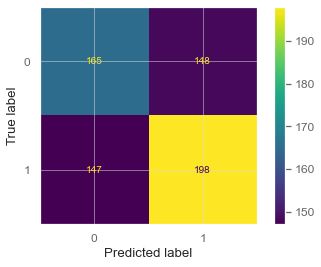

In [16]:
xgboost_model_1 = Model(XGBClassifier, data, seed=0, scale_pos_weight=0.9, objective='binary:logistic')

fit_params={"early_stopping_rounds":3, 
            "eval_metric" : "error",
            "verbose":0,
            "eval_set" : [[data.X_test, data.y_test]]}

param_grid = {'learning_rate': [0.001, 0.01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [1, 12],
              'lambda': [1, 1.5],
              'gamma': [0, 0.5],
              'colsample_bytree': [0.6, 0.7],
              'subsample': [0.8, 0.9, 1]}
            
cv_parms={'return_train_score':True, 'verbose':2, 'n_jobs':5, 'param_grid': param_grid, 'cv': TimeSeriesSplit(n_splits=5), 'scoring': 'balanced_accuracy'}
xgboost_model_1.cross_validation_train(cv_params=cv_parms, fit_params=fit_params)
xgboost_model_1.confusion_matrix()

Fitting 3 folds for each of 192 candidates, totalling 576 fits
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=0, subsample=None, tree_method=None,
                                    validate_parameters=None, ve

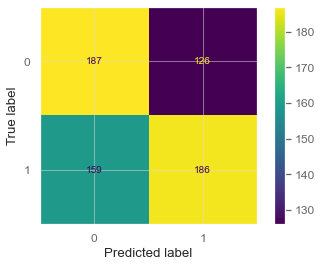

In [17]:
xgboost_model_2 = Model(XGBRegressor, data, seed=0, objective='reg:logistic')

fit_params={"early_stopping_rounds":3, 
            "eval_metric" : "logloss",
            "verbose":0,
            "eval_set" : [[data.X_test, data.y_test]]}

param_grid = {'learning_rate': [0.01, 0.001],
              'max_depth': [3, 10],
              'lambda': [1, 1.5],
              'gamma': [1, 0.5],
              'colsample_bytree': [0.5, 0.7],
              'subsample': [0.6, 0.7],
              'max_delta_step': [2,5,10]}

cv_parms={'return_train_score':True, 'verbose':2, 'n_jobs':5, 'param_grid': param_grid, 'cv': TimeSeriesSplit(n_splits=3), 'scoring':'r2'}
xgboost_model_2.cross_validation_train(cv_params=cv_parms, fit_params=fit_params)
xgboost_model_2.confusion_matrix()

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             error_score='raise', estimator=AdaBoostClassifier(random_state=0),
             n_jobs=5,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1,
                                                                   min_samples_leaf=25,
                                                                   min_samples_split=150),
                                            DecisionTreeClassifier(max_depth=1,
                                                                   min_samples_leaf=25,
                                                                   min_samples_split=200),
                                            Decis...
                                            DecisionTreeClassifier(max_depth=5,
                                                                   min_samples_leaf=50,
     

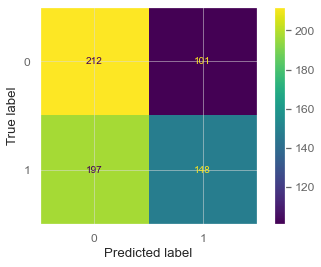

In [18]:
adaboost_model_1 = Model(AdaBoostClassifier, data, random_state=0)

def get_combinations(**kwargs):
    return [{list(kwargs)[i]: c for i, c in enumerate(prod)} for prod in product(*kwargs.values())]

base_estimators = get_combinations(max_depth= [1,2,3,4,5,6,7], min_samples_leaf=[25, 50, 100], min_samples_split= [150, 200])
param_grid = {"base_estimator" : [DecisionTreeClassifier(**kwargs) for kwargs in base_estimators],
              'learning_rate': [0.001, 0.01, 0.1, 1],
              'n_estimators': [50, 100, 150]}

cv_parms={'return_train_score':True, 'verbose':2, 'n_jobs':5, 'scoring':'accuracy', 'param_grid': param_grid, 'cv': TimeSeriesSplit(n_splits=3), 'scoring':'balanced_accuracy'}
adaboost_model_1.cross_validation_train(cv_params=cv_parms)
adaboost_model_1.confusion_matrix()

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             error_score='raise', estimator=AdaBoostRegressor(random_state=0),
             n_jobs=5,
             param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=3,
                                                                  min_samples_leaf=25,
                                                                  min_samples_split=150),
                                            DecisionTreeRegressor(max_depth=3,
                                                                  min_samples_leaf=25,
                                                                  min_samples_split=200),
                                            Decision...
                                                                  min_samples_split=150),
                                            DecisionTreeRegressor(max_depth=7,
        

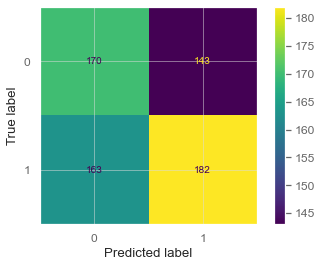

In [19]:
adaboost_model_2 = Model(AdaBoostRegressor, data, random_state=0)

base_estimators = get_combinations(max_depth=[3,4,5,6,7], min_samples_leaf=[25, 50, 100], min_samples_split= [150, 200])
param_grid = {"base_estimator" : [DecisionTreeRegressor(**kwargs) for kwargs in base_estimators],
              'learning_rate': [0.001, 0.01, 0.1, 1],
              'n_estimators': [50, 100, 150]}

cv_parms={'return_train_score':True, 'verbose':2, 'n_jobs':5, 'param_grid': param_grid, 'cv': TimeSeriesSplit(n_splits=3), 'scoring':'r2'}
cv = adaboost_model_2.cross_validation_train(cv_params=cv_parms)
adaboost_model_2.confusion_matrix()

Question 4. Provide P&L backtesting plots (cumulative returns) for Kelly optimal bets vs. 100% bets.
Kelly allocation to the asset computed with probability p taken from predict proba() is as follows:
p − (1 − p) = 2p − 1

Therefore, you remain in cash for 1−(2p−1) = 2(1−p) percentage, which reduces your gain (and loss).
Worked example: allocation 75% into a risky asset that moves up 5%, while 25% remained in a broker
account earning 0%, gives the total gain of 0.75 ⇥ 0.05 + 0.25 ⇥0 = 3.75%.

To obtain sensible probabilities from trees method you might need to use Regressor or non-optimal
min samples leaf. Assume daily betting on price direction. Use the realised return value with PREDICTED
sign to compute profit (loss) for end of the day. P&L can have a more profitable path than the
asset price evolution (long-only strategy) because of successful bets on negative moves.

In [21]:
def backtest(ml_model: Model):

    start = round(-len(data.y_test))
    backtest_df = data.df[start:].copy()
    print(backtest_df.DATE.min(), backtest_df.DATE.max())

    X = backtest_df.drop(list(data.non_features), axis=1)

    backtest_df['PROB_UP'] = ml_model.model.predict(X)
    backtest_df['PROB_DOWN'] = 1- backtest_df['PROB_UP']

    backtest_df[['PROB_DOWN', 'PROB_UP']] = backtest_df[['PROB_DOWN', 'PROB_UP']].shift(1)
    backtest_df['STRATEGY'] = np.argmax(backtest_df[['PROB_DOWN', 'PROB_UP']].values, axis=1)
    backtest_df.dropna(inplace=True)
    backtest_df['100_STRATEGY'] = np.where(backtest_df['STRATEGY'] == 1 ,backtest_df['RETURN'], backtest_df['RETURN']*-1)
    backtest_df['KELLY_OPTIMAL_STRATEGY'] = np.where(backtest_df['PROB_UP'] > 0.5, backtest_df['RETURN']*backtest_df['PROB_UP'], backtest_df['RETURN']*-1*backtest_df['PROB_DOWN'])
    backtest_df.set_index('DATE', inplace=True)
    return backtest_df


In [22]:
back_test_df = backtest(xgboost_model_2)

2020-08-08 00:00:00 2022-05-27 00:00:00


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-08-09  2020-08-09
End Period                 2022-05-27  2022-05-27
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          364.47%     50.61%
CAGR﹪                     135.02%     25.59%

Sharpe                     1.28        0.56
Prob. Sharpe Ratio         98.1%       81.78%
Smart Sharpe               1.28        0.56
Sortino                    1.96        0.81
Smart Sortino              1.96        0.81
Sortino/√2                 1.38        0.57
Smart Sortino/√2           1.38        0.57
Omega                      1.25        1.25

Max Drawdown               -40.64%     -66.9%
Longest DD Days            272         408
Volatility (ann.)          60.38%      60.53%
R^2                        0.0         0.0
Information Ratio          0.03        0.03
Calmar                     3.32        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-12-16,2021-01-08,2021-02-08,54,-40.635113,-40.133272
2,2021-08-04,2022-02-15,2022-05-03,272,-37.641488,-35.097707
3,2021-02-11,2021-03-13,2021-05-04,82,-23.517534,-22.547995
4,2021-05-16,2021-05-19,2021-05-24,8,-22.829027,-15.178090
5,2022-05-06,2022-05-09,2022-05-19,13,-18.358799,-15.904057


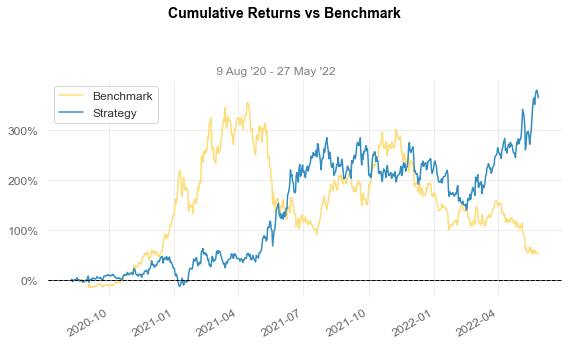

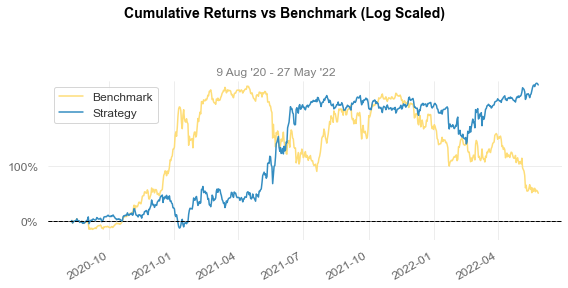

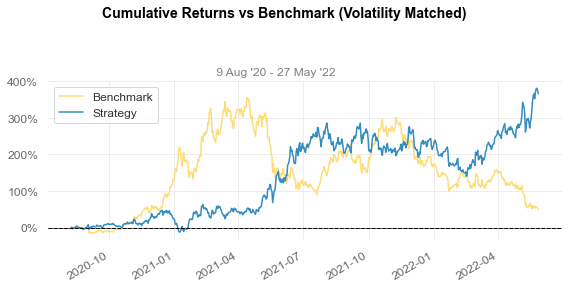

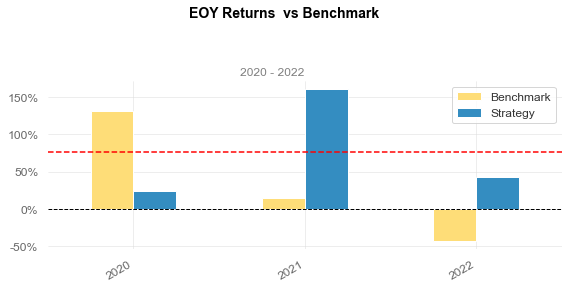

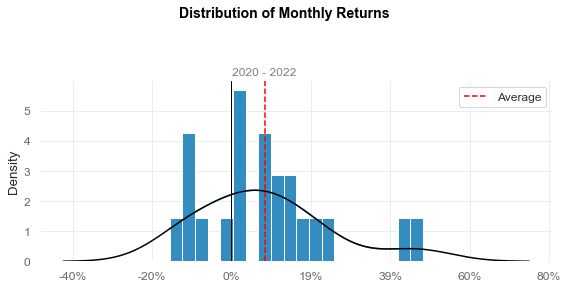

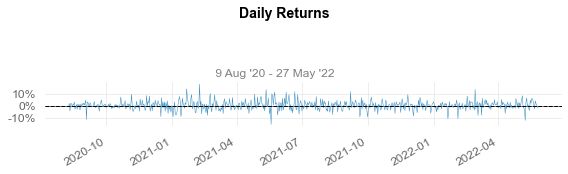

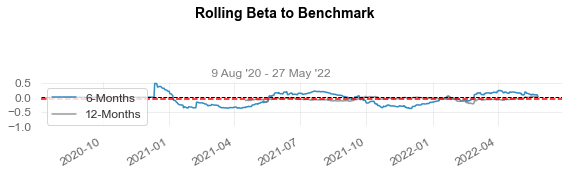

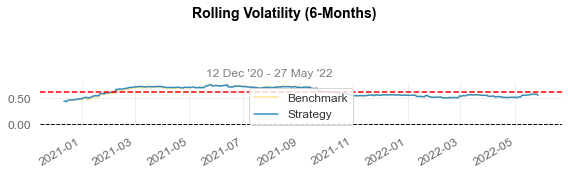

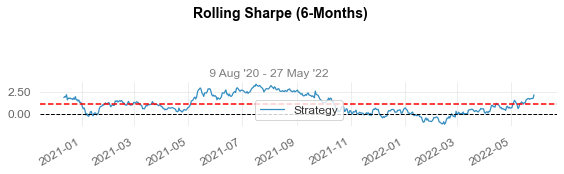

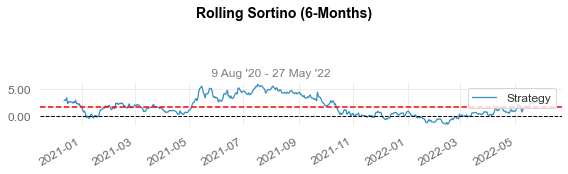

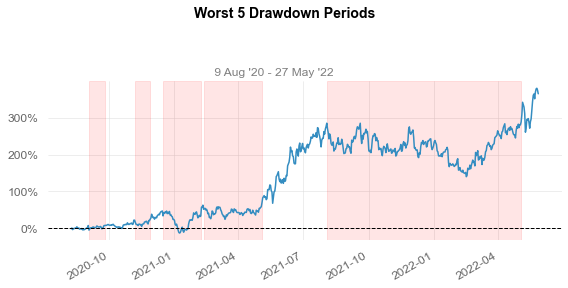

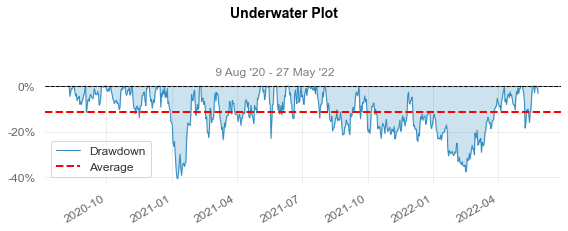

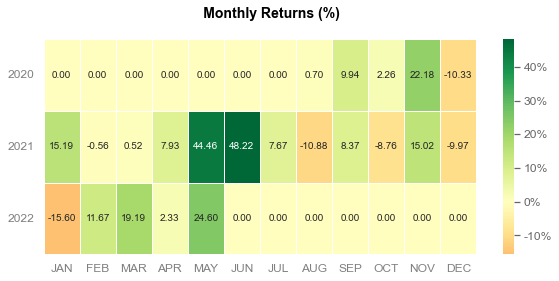

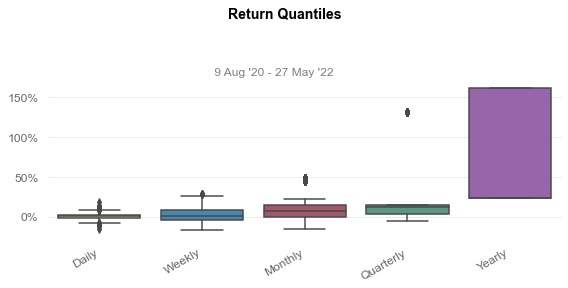

In [23]:
qs.reports.full(back_test_df['100_STRATEGY'], benchmark=back_test_df['RETURN'], match_dates=True)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-08-09  2020-08-09
End Period                 2022-05-27  2022-05-27
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          146.01%     50.61%
CAGR﹪                     65.02%      25.59%

Sharpe                     1.27        0.56
Prob. Sharpe Ratio         98.05%      81.78%
Smart Sharpe               1.27        0.56
Sortino                    1.94        0.81
Smart Sortino              1.94        0.81
Sortino/√2                 1.37        0.57
Smart Sortino/√2           1.37        0.57
Omega                      1.25        1.25

Max Drawdown               -22.68%     -66.9%
Longest DD Days            200         408
Volatility (ann.)          30.95%      60.53%
R^2                        0.0         0.0
Information Ratio          0.0         0.0
Calmar                     2.87        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-12-16,2021-01-08,2021-01-31,46,-22.681934,-22.352809
2,2021-09-20,2022-02-15,2022-04-08,200,-19.950245,-18.336388
3,2021-02-11,2021-03-13,2021-05-04,82,-12.463627,-12.114408
4,2021-05-16,2021-05-19,2021-05-23,7,-12.389098,-7.820683
5,2021-08-04,2021-08-27,2021-09-19,46,-11.090852,-10.940355


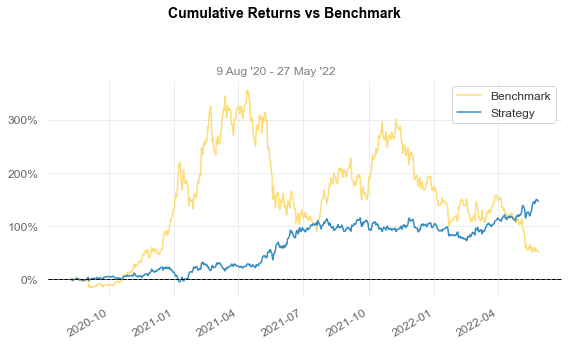

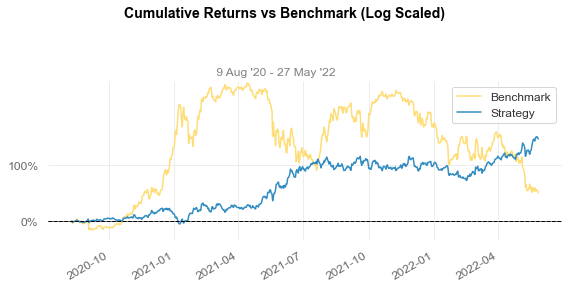

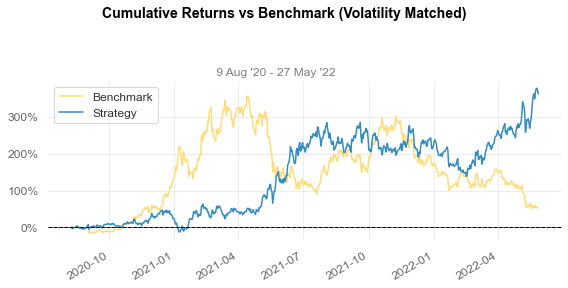

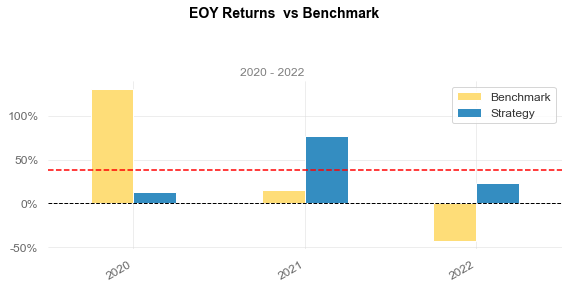

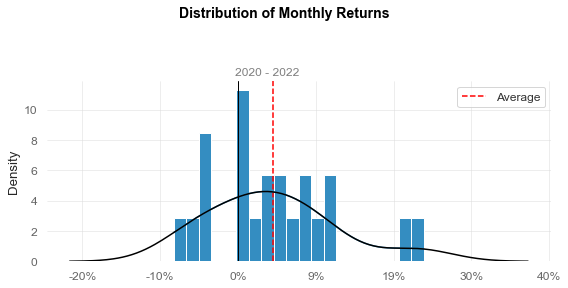

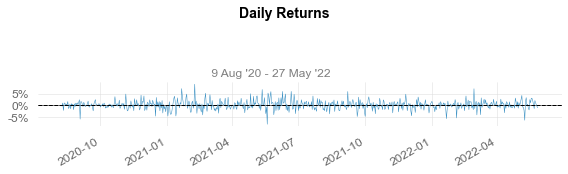

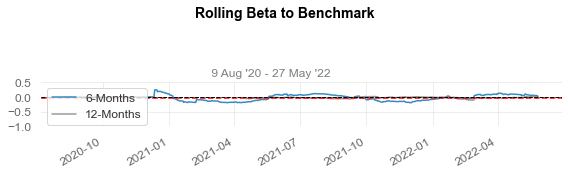

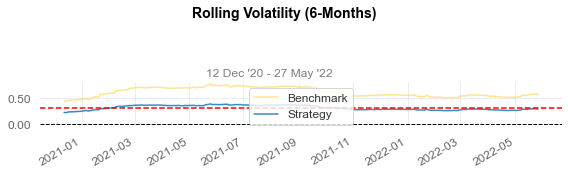

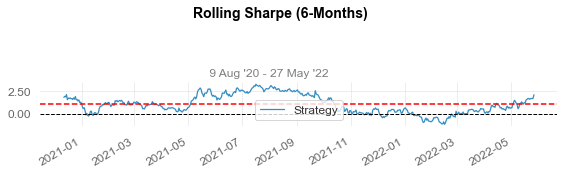

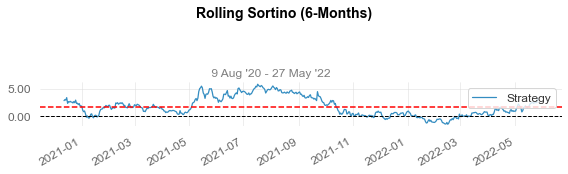

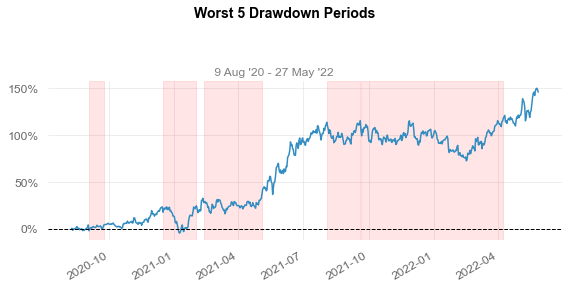

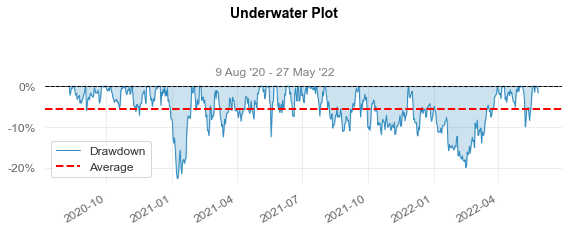

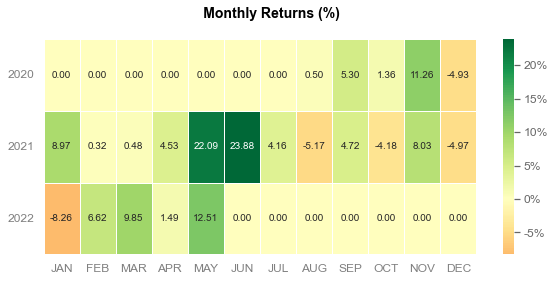

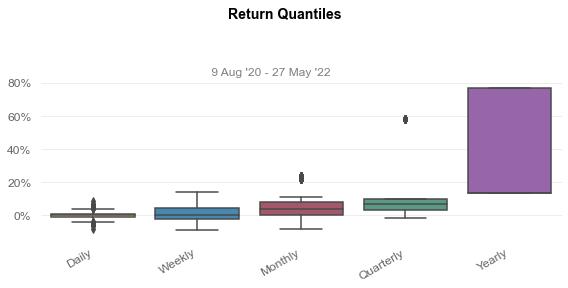

In [24]:
qs.reports.full(back_test_df['KELLY_OPTIMAL_STRATEGY'], benchmark=back_test_df['RETURN'], match_dates=True)